# Ví dụ 1.  
Sử dụng CNN trong thư viện Keras TensorFlow để phân loại ảnh chó mèo.  
(Phân loại nhị phân)

## Chuẩn bị hệ thống

In [1]:
import tensorflow as tf
print(tf.__version__)

2024-04-08 08:45:55.516772: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 08:45:55.516884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 08:45:55.583675: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-08 08:45:55.750174: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-08 08:45:58.833573: W tensorflow/compiler/tf2

2.15.0


In [2]:
import jupyter
print(jupyter.__version__)

1.0.0


In [3]:
import scipy
print(scipy.__version__)

1.9.3


## Chuẩn bị dữ liệu

Hiển thị ra cấu trúc file, folder lưu trữ dữ liệu

In [4]:
import os

base_dir = "data/cat_dog_panda"
# Change the base_dir to where you put dataset
print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f"{base_dir}/train"))

print("\nContents of validation directory:")
print(os.listdir(f"{base_dir}/validation"))

Contents of base directory:
['train', 'validation']

Contents of train directory:
['cats', 'dogs', 'panda']

Contents of validation directory:
['cats', 'dogs', 'panda']


Tham chiếu phân lớp vào tập train và validation (tên thư mục là tên phân lớp)

In [5]:
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, "cats")
train_dogs_dir = os.path.join(train_dir, "dogs")

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, "cats")
validation_dogs_dir = os.path.join(validation_dir, "dogs")

print("\nContents of train directory:")
print(os.listdir(f"{base_dir}/train"))

print("\nContents of validation directory:")
print(os.listdir(f"{base_dir}/validation"))


Contents of train directory:
['cats', 'dogs', 'panda']

Contents of validation directory:
['cats', 'dogs', 'panda']


Lấy danh sách tên file từng loại ảnh train/validation và thống kê số data có cho mỗi phân lớp

In [6]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

print("total training cat images :", len(os.listdir(train_cats_dir)))
print("total training dog images :", len(os.listdir(train_dogs_dir)))

print("total validation cat images :", len(os.listdir(validation_cats_dir)))
print("total validation dog images :", len(os.listdir(validation_dogs_dir)))

['cats_00306.jpg', 'cats_00612.jpg', 'cats_00001.jpg', 'cats_00002.jpg', 'cats_00003.jpg', 'cats_00004.jpg', 'cats_00005.jpg', 'cats_00006.jpg', 'cats_00007.jpg', 'cats_00008.jpg']
['dogs_00306.jpg', 'dogs_00612.jpg', 'dogs_00001.jpg', 'dogs_00002.jpg', 'dogs_00003.jpg', 'dogs_00004.jpg', 'dogs_00005.jpg', 'dogs_00006.jpg', 'dogs_00007.jpg', 'dogs_00008.jpg']
total training cat images : 1000
total training dog images : 1000
total validation cat images : 1000
total validation dog images : 1000


In 1 số ảnh mỗi loại để kiểm tra

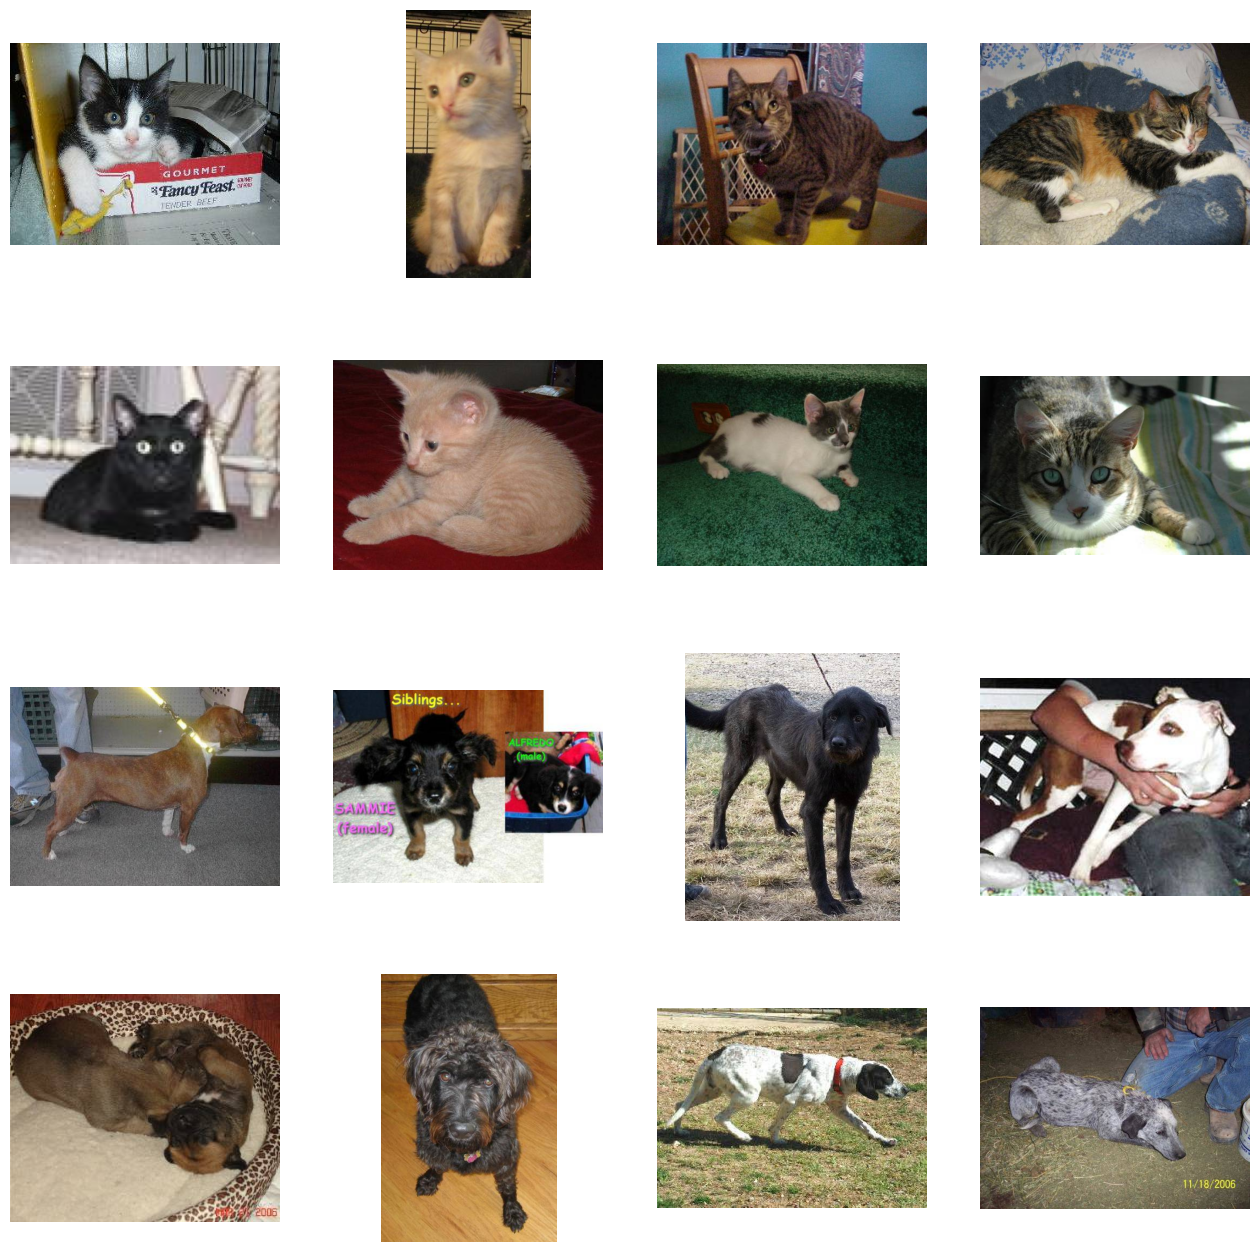

In [7]:
%matplotlib inline 
 
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
 
# Parameters for our graph; we'll output images in a 4x4 configuration 
nrows = 4 
ncols = 4 
 
pic_index = 0 # Index for iterating over images 
# Set up matplotlib fig, and size it to fit 4x4 pics 
fig = plt.gcf() 
fig.set_size_inches(ncols*4, nrows*4) 
 
pic_index += 8 
 
next_cat_pix = [os.path.join(train_cats_dir, fname)  
                for fname in train_cat_fnames[ pic_index-8:pic_index]  
               ] 

next_dog_pix = [os.path.join(train_dogs_dir, fname)  
                for fname in train_dog_fnames[ pic_index-8:pic_index] 
               ] 
 
for i, img_path in enumerate(next_cat_pix+next_dog_pix): 
  # Set up subplot; subplot indices start at 1 
  sp = plt.subplot(nrows, ncols, i + 1) 
  sp.axis('Off') # Don't show axes (or gridlines) 
 
  img = mpimg.imread(img_path) 
  plt.imshow(img) 
 
plt.show() 

## Khởi tạo CNN

Kiến trúc mạng CNN sẽ xây dựng:  
- 3 tầng tích chập (convolution layers) kết hợp với Pooling (MaxPooling layers), kích thước mặt nạ tích chập là 3x3, kích thước pooling là 2x2.  
- Sau mỗi tầng tích chập, hàm kích hoạt được sử dụng là ReLU.  
- Tiếp theo là một tầng Flatten và tầng tiếp theo là Full Connection (duỗi các kết quả đầu ra thành vector).  
- Cuối cùng là một tầng phân loại ở đầu ra, sử dụng hàm Sigmoid (logistic – vì đây chỉ có 02 lớp).

In [8]:
import tensorflow as tf

model = tf.keras.models.Sequential(
    [
        # Note the input shape is the desired size of the image 150x150 with 3 bytes color
        tf.keras.layers.Conv2D(
            16, (3, 3), activation="relu", input_shape=(150, 150, 3)
        ),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation="relu"),
        # Only 1 output neuron.
        # It will contain a value from 0-1 
        # where 0 for 1 class ('cats')
        # and 1 for the other ('dogs')
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

In [9]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

## Huấn luyện CNN

Thiết lập phương pháp giải bài toán tối ưu. Ở đây ta dùng RMSprop thay cho SGD (do có thể tự động chọn tham số học)

In [10]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

Tiếp theo chúng ta chuẩn hóa dữ liệu bằng các đưa cường độ pixel về khoảng [0, 1], chỉnh kích thước ảnh về 150x150 và điều hướng các thư mục chứa dữ liệu training 

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Define the list of classes you want to use (excluding the folder you want to exclude)
classes = [class_name for class_name in os.listdir(train_dir) if class_name != 'panda']

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode="binary", target_size=(150, 150), classes=classes
)
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator = test_datagen.flow_from_directory(
    validation_dir, batch_size=20, class_mode="binary", target_size=(150, 150), classes=classes
)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Lệnh huấn luyện mô hình  

In [14]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2,
)

Epoch 1/15
100/100 - 75s - loss: 0.7548 - accuracy: 0.5050 - val_loss: 0.6803 - val_accuracy: 0.5000 - 75s/epoch - 752ms/step
Epoch 2/15
100/100 - 66s - loss: 0.6834 - accuracy: 0.5905 - val_loss: 0.6188 - val_accuracy: 0.6710 - 66s/epoch - 660ms/step
Epoch 3/15
100/100 - 78s - loss: 0.6045 - accuracy: 0.6860 - val_loss: 0.5169 - val_accuracy: 0.7330 - 78s/epoch - 782ms/step
Epoch 4/15
100/100 - 78s - loss: 0.5488 - accuracy: 0.7105 - val_loss: 0.4764 - val_accuracy: 0.8000 - 78s/epoch - 784ms/step
Epoch 5/15
100/100 - 73s - loss: 0.5004 - accuracy: 0.7465 - val_loss: 0.4285 - val_accuracy: 0.8000 - 73s/epoch - 726ms/step
Epoch 6/15
100/100 - 68s - loss: 0.4361 - accuracy: 0.7975 - val_loss: 0.3229 - val_accuracy: 0.8590 - 68s/epoch - 684ms/step
Epoch 7/15
100/100 - 77s - loss: 0.3592 - accuracy: 0.8500 - val_loss: 0.2439 - val_accuracy: 0.9240 - 77s/epoch - 766ms/step
Epoch 8/15
100/100 - 75s - loss: 0.2741 - accuracy: 0.8880 - val_loss: 0.1419 - val_accuracy: 0.9550 - 75s/epoch - 751

In [16]:
model.save("best_model_cat_dog_no_dropout.keras")

Xem xét 1 số kết quả, chúng ta sẽ in ra kết quả sau mỗi tầng ("ảnh" đầu ra sau mỗi tầng convolution và maxpool) để hiểu thêm cách hoạt động của CNN để cho ra dãy so sánh được ở tầng flatten.

1/1 [==============================] - 0s 204ms/step


/tmp/ipykernel_22463/1428360066.py:50: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
/tmp/ipykernel_22463/1428360066.py:53: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype("uint8")


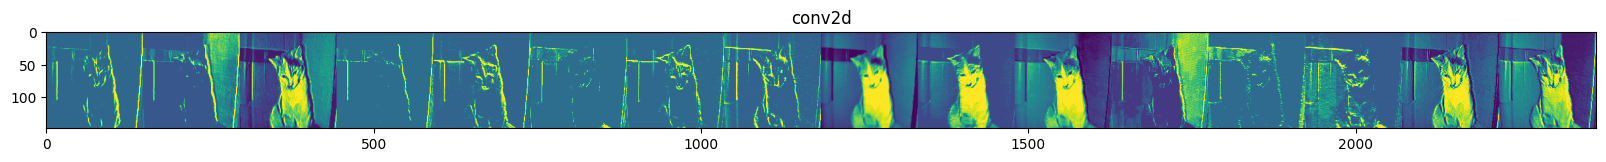

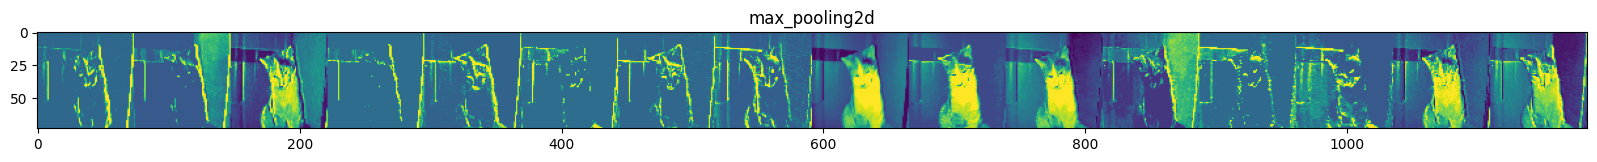

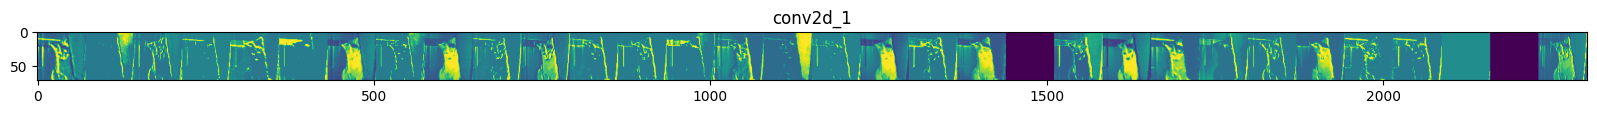

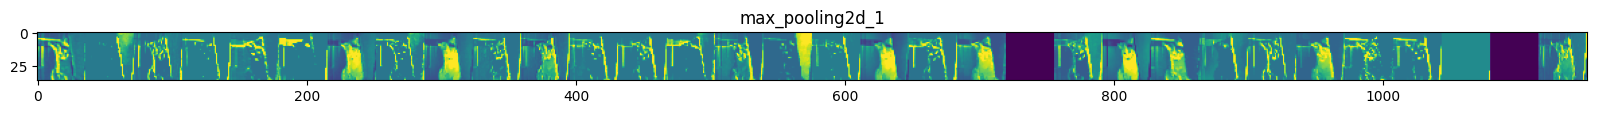

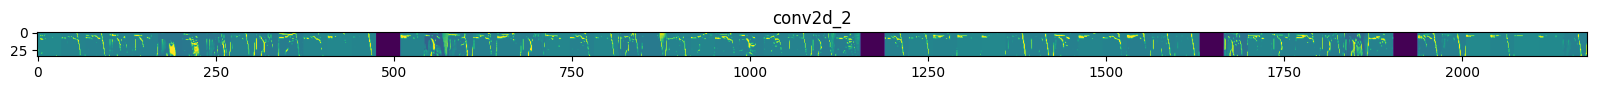

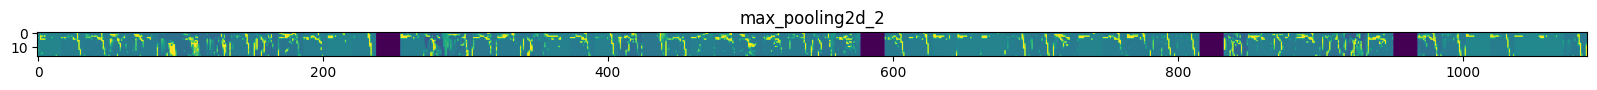

In [17]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(
    inputs=model.input, outputs=successive_outputs
)

# Prepare a random input image from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Scale by 1/255
x /= 255.0

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so we can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):

    if len(feature_map.shape) == 4:

        # -------------------------------------------
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        # -------------------------------------------
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size = feature_map.shape[1]  # feature map shape (1, size, size, n_features)

        # Tile the images in this matrix
        display_grid = np.zeros((size, size * n_features))

        # -------------------------------------------------
        # Postprocess the feature to be visually palatable
        # -------------------------------------------------
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype("uint8")
            display_grid[:, i * size : (i + 1) * size] = (
                x  # Tile each filter into a horizontal grid
            )

        # -----------------
        # Display the grid
        # -----------------
        scale = 20.0 / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect="auto", cmap="viridis")

## Thử nghiệm trên tập validation

Thử test với 1 ảnh bất kỳ

In [19]:
import numpy as np 
 
#from google.colab import files 
from keras.preprocessing import image 
 
#uploaded=files.upload() 
 
#for fn in uploaded.keys(): 
fn =  'cats_00001.jpg' # change it to your image file 
# predicting images 
path='/mnt/DataK/Univer/UniSubject/_3th_year/_2nd_term/3ii_ML/Lec_Ass/Week8/data/cat_dog_panda/validation/cats/cats_00001.jpg' # change it to your image 
img=image.load_img(path, target_size=(150, 150)) 
 
x=image.img_to_array(img) 
x /= 255 
x=np.expand_dims(x, axis=0) 
images = np.vstack([x]) 
 
classes = model.predict(images, batch_size=10) 
 
print(classes[0]) 
 
if classes[0]>0.5: 
    print(fn + " is a dog" ) 
else: 
    print(fn + " is a cat" )

1/1 [==============================] - 0s 237ms/step
[7.743724e-05]
cats_00001.jpg is a cat


Tính toán độ chính xác, hàm tổn thất khi test trên tập validation

Text(0.5, 1.0, 'Training and validation loss')

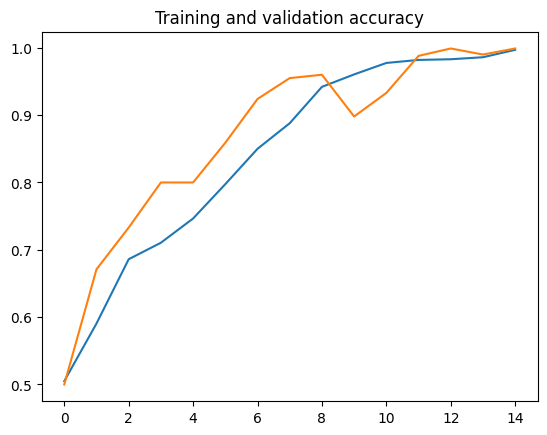

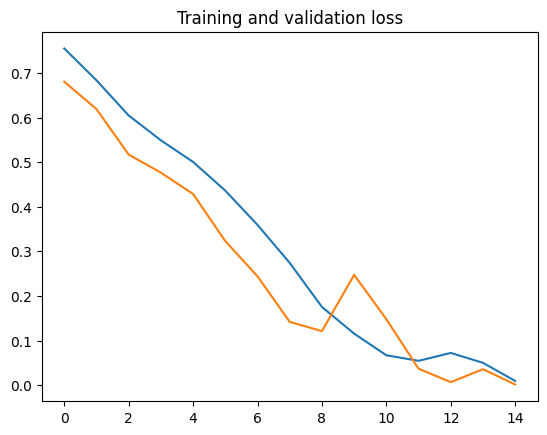

In [20]:
# -----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
# -----------------------------------------------------------
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))  # Get number of epochs

# ------------------------------------------------
# Plot training and validation accuracy per epoch
# ------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title("Training and validation accuracy")
plt.figure()

# ------------------------------------------------
# Plot training and validation loss per epoch
# ------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title("Training and validation loss")

## Phần tự thực hành

### Quan sát Loss Function và Accuracy trên tập Training và trên tập Validation với Model CNN trên - chưa có layer dropout. Giải thích những kết quả quan sát được.

Dựa theo file code của thầy thì quá trình train sẽ bị overfitting, cụ thể nguyên văn:  

'As you can see, the model is **overfitting**. The training accuracy (in blue) gets close to 100% while the validation accuracy (in orange) stalls as 70%. The validation loss reaches its minimum after only five epochs.  
  
Since we have a relatively small number of training examples (2000), overfitting should be the number one concern. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data.'  
  
Tuy nhiên dựa trên biểu đồ sự thay đổi về Accuracy và Loss Function ở trên thì Accuracy và Loss Function ở cả train và validation đều tăng ở Accuracy và đều giảm trên Loss Function giống nhau. Tức là không bị trường hợp Overfitting.  
  
Sự khác biệt với bài của thầy chỉ là thay vì dùng 2000 ảnh (1000 ảnh cho mỗi lớp trong 2 lớp) tải từ mledu-datasets thì em dùng luôn 2000 ảnh từ dữ liệu bài 2 (có 3 lớp - đã loại bỏ dữ liệu lớp Panda đi). Còn lại kiến trúc Model giữ nguyên. **Như vậy sự khác biệt để không bị overfitting như của thầy là do sự khác biệt về dữ liệu**

### Hãy bổ sung các tầng Dropout này vào giữa các tầng Convolution, rate_drop khoảng từ 0.3 đến 0.5 và quan sát kết quả sau khi thay đổi của Model CNN đã có thêm layer dropout.  
Trong thư viện tensorflow.keras.layer có một loại layer là Dropout(rate = <rate_drop>), trong đó giá trị của rate_drop thuộc [0, 1). Layer Dropout cho phép bỏ bớt dữ liệu train với tỉ lệ là rate_drop, nhằm mục đích tránh overfit. 

Về việc đặt các lớp Dropout với tỷ lệ sao cho hợp lý:  
Việc **thiết lập tỷ lệ Dropout lớn hơn ở các tầng sâu hơn** có thể có một số lợi ích trong việc đối phó với overfitting và cải thiện tính tổng quát hóa của mô hình. Dưới đây là một số lý do:  
  
1. **Giảm kích thước đầu vào**: Khi chúng ta đi sâu vào mạng nơ-ron, kích thước đầu vào cho các tầng tiếp theo thường nhỏ hơn do sự giảm kích thước của các tensor khi đi qua các tầng trước đó. Do đó, việc loại bỏ một phần lớn dữ liệu tại các tầng sau có thể giúp ngăn chặn hiện tượng overfitting.  
  
2. **Tăng cường tính đa dạng**: Càng sâu vào mạng, các đặc trưng trừu tượng và phức tạp hơn thường được học. Việc loại bỏ một phần lớn kết nối ở các tầng sau có thể buộc mô hình học cách sử dụng các đặc trưng này một cách chính xác và đa dạng hơn, thay vì dựa quá nhiều vào các đặc trưng cụ thể.  
  
3. **Giảm thiểu overfitting**: Overfitting thường xảy ra khi mô hình học các quan hệ không tổng quát từ dữ liệu huấn luyện. Việc loại bỏ một phần lớn các kết nối thông qua Dropout ở các tầng sâu có thể giảm thiểu khả năng mô hình học các mối quan hệ cụ thể trong dữ liệu huấn luyện mà không phản ánh các mẫu tổng quát.  
  
4. **Tăng tính linh hoạt và dễ tái sử dụng**: Việc sử dụng tỷ lệ Dropout lớn ở các tầng sâu có thể làm cho mô hình trở nên linh hoạt hơn và dễ dàng tái sử dụng. Điều này có thể giúp mô hình hoạt động tốt trên nhiều tập dữ liệu khác nhau và tránh overfitting trên dữ liệu mới.  
  
Tuy nhiên, việc thiết lập tỷ lệ Dropout lớn hơn ở các tầng sâu cũng cần được cân nhắc cẩn thận, vì một tỷ lệ quá lớn có thể dẫn đến việc mất mát thông tin quá nhiều và làm giảm hiệu suất của mô hình trên dữ liệu kiểm tra. Do đó, việc điều chỉnh tỷ lệ Dropout cần phải được thực hiện dựa trên thử nghiệm và đánh giá kết quả trên dữ liệu thực tế.  

In [21]:
import tensorflow as tf

model_with_dropout = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.Dropout(0.3),  # Adding Dropout layer after the first convolutional layer
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Dropout(0.4),  # Adding Dropout layer after the second convolutional layer
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Adding Dropout layer after the third convolutional layer
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Adding Dropout layer before the output layer
    # Only 1 output neuron.
    # It will contain a value from 0-1 where 0 for 1 class ('cats')
    # and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [22]:
from tensorflow.keras.optimizers import RMSprop

model_with_dropout.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [23]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# Define a callback to save the best model during training
checkpoint = ModelCheckpoint(
    "best_model_cat_dog_with_dropout.keras",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    mode="max",
)

# Train the model
history = model_with_dropout.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2,
    callbacks=[checkpoint],
)

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.48600, saving model to best_model_cat_dog_with_dropout.keras
100/100 - 99s - loss: 1.1189 - accuracy: 0.5265 - val_loss: 0.6946 - val_accuracy: 0.4860 - 99s/epoch - 995ms/step
Epoch 2/15

Epoch 2: val_accuracy improved from 0.48600 to 0.63900, saving model to best_model_cat_dog_with_dropout.keras
100/100 - 90s - loss: 0.7153 - accuracy: 0.5685 - val_loss: 0.6704 - val_accuracy: 0.6390 - 90s/epoch - 897ms/step
Epoch 3/15

Epoch 3: val_accuracy improved from 0.63900 to 0.66800, saving model to best_model_cat_dog_with_dropout.keras
100/100 - 84s - loss: 0.6641 - accuracy: 0.6305 - val_loss: 0.6453 - val_accuracy: 0.6680 - 84s/epoch - 842ms/step
Epoch 4/15

Epoch 4: val_accuracy improved from 0.66800 to 0.80300, saving model to best_model_cat_dog_with_dropout.keras
100/100 - 91s - loss: 0.6078 - accuracy: 0.6770 - val_loss: 0.5987 - val_accuracy: 0.8030 - 91s/epoch - 912ms/step
Epoch 5/15

Epoch 5: val_accuracy did not improve from 

Text(0.5, 1.0, 'Training and validation loss')

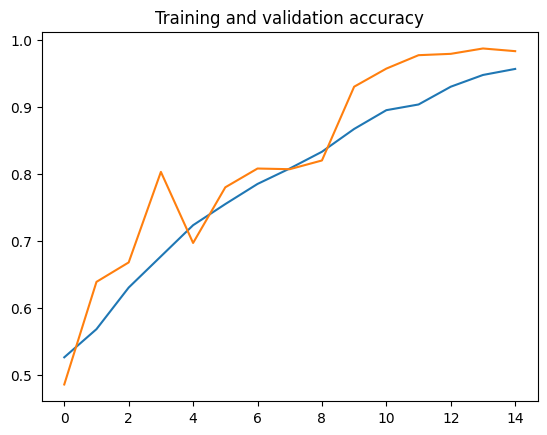

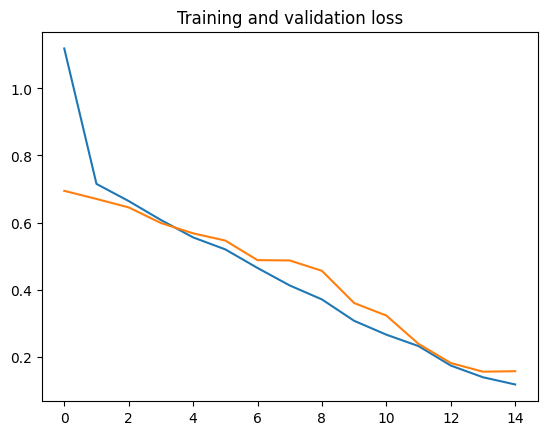

In [24]:
# -----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
# -----------------------------------------------------------
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))  # Get number of epochs

# ------------------------------------------------
# Plot training and validation accuracy per epoch
# ------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title("Training and validation accuracy")
plt.figure()

# ------------------------------------------------
# Plot training and validation loss per epoch
# ------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title("Training and validation loss")

In [ ]:
# Load the best saved model
# best_model_cat_dog_with_dropout = tf.keras.models.load_model('best_model_cat_dog_with_dropout.keras')

# Evaluate the best model
# test_loss, test_acc = model_with_dropout.evaluate(validation_generator)
# print("Test Accuracy:", test_acc)
# print("Test Loss:", test_loss)

### Sử dụng mô hình Hồi quy Logistic

#### Đưa dữ liệu về size 150x150

In [ ]:
...

#### Chuyển ảnh về vector

In [ ]:
...

#### Sử dụng hồi quy Logistic

In [ ]:
...

#### Đánh giá các độ đo

In [ ]:
...

### Sử dụng mạng ANN 

#### Dùng PCA giảm số chiều về 225

In [ ]:
...

#### Train ANN

In [ ]:
...

#### Đánh giá các độ đo

In [ ]:
...

### Nhận xét kết quả các độ đo của 3 phương pháp: Dùng ANN, Dùng Logistic, Dùng CNN

...

### Sưu tầm dữ liệu mới để test cho cả 3 phương pháp

#### Sưu tầm >= 10 ảnh cho mỗi nhãn (có 2 nhãn)

In [ ]:
...

#### Thực hiện test dùng CNN

In [ ]:
...

#### Thực hiện test dùng Logistic

In [ ]:
...

#### Thực hiện test dùng ANN

In [ ]:
...

# Ví dụ 2.  
Dữ liệu vấn là bên trên nhưng bổ sung thêm Panda  
(Phân loại nhiều lớp > 2 class)  

## Chuẩn bị hệ thống

In [ ]:
import tensorflow as tf # Thư viện tensor.flow 
from tensorflow import keras # Lớp keras và các công cụ liên quan 
import tensorflow_datasets as tfds # Gọi và xử lý dữ liệu (với label là tên folder chứa dữ liệu) 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score

## Thiết lập kiến trúc mạng CNN

In [ ]:
...

## Đọc vào dữ liệu

In [ ]:
...

## Train CNN và visualize kết quả accuracy trên train set và validation set

In [ ]:
...

## Phần tự thực hành

### So sánh với Hồi quy SOFTMAX & ANN

#### Sử dụng hồi quy SOFTMAX

##### Đưa dữ liệu về size 150x150

In [ ]:
...

##### Thực hiện hồi quy SOFTMAX

In [ ]:
...

#### Sử dụng ANN

##### Giảm số chiều về 225

In [ ]:
...

##### Thực hiện phân loại với ANN

In [ ]:
...

#### So sánh kết quả Accuracy của SOFTMAX, ANN, CNN trên train và valid set

In [ ]:
...

### Một số tùy chỉnh với CNN để quan sát sự thay đổi của độ chính xác  

#### Thử nghiệm riêng lẻ với 1 vài dữ liệu test (tự kiếm)

In [ ]:
...

#### Đưa về phân loại 2 lớp (chỉ chó và mèo) nhưng giữ nguyên hàm kích hoạt tầng đầu ra là SOFTMAX

##### Chỉ lấy 300 cho training và 100 cho validation

In [ ]:
...

##### Train model và các chỉ số

In [ ]:
...

##### Bổ sung các tầng Dropout vào giữa các tầng Convolution của mạng CNN ban đầu (bài toán phân loại 3 class với data 1000 ảnh ở mỗi class ở mỗi tập train và valid), rate_drop khoảng từ 0.3 đến 0.5 và quan sát kết quả sau khi thay đổi.

###### Bổ sung Dropout vào kiến trúc mạng CNN

In [ ]:
...

###### Train CNN

In [ ]:
...

###### Quan sát các chỉ số đánh giá

In [ ]:
...

###### Thực hiện test thử nghiệm với dữ liệu tự kiếm

In [ ]:
...

# Ví dụ 3. (Bài tập tự thực hành)  
Sử dụng CNN phân loại 11 lớp cảm xúc từ hình ảnh khuôn mặt.  
(Phân loại nhiều nhãn (>= 3))
So sánh với dùng ANN và Logistic.

## Đọc vào dữ liệu

In [ ]:
...

## Phân chia train:test tỷ lệ 8:2

In [ ]:
...

## Huấn luyện CNN (kiến trúc như của Ví dụ 2)

### Thiết lập kiến trúc CNN

In [ ]:
...

### Huấn luyện CNN

In [ ]:
...

### Dự đoán trên tập test

In [ ]:
...

### Accuracy, Precision, Recall trên train set và test set

In [ ]:
...

### Giải thích kết quả thu được 

### So sánh với cách dùng Logistic (đã resize lại ảnh) và ANN (đã thực hiện giảm số chiều)

#### Sử dụng Logistic 

#### Sử dụng ANN 